# Results
In this notebook are collected and presented the results for the Task 1 of the QOSF Mentorship Program 2020. For details about the task and the code structure please refer to the README.md.

## Method
The following results have been obtained using the Adam optimizer of the Tensorflow library.<br>
As first step the scipy 'Nelder-Mead' optimizer has been used, because it conveniently does not need the gradients. Convergence was relatively fast, but the error was not minimized as much as desired. <br>
Therefore, the idea to switch to Tensorflow and take advantage of the Adam optimization and gradient calculation. Switching optimizer, reformulate the problem to correctly build the tensorflow graph and find the optimal configuration took most of the project time, leaving small space for additional interesting checks. <br>

## Imports

In [1]:
%matplotlib inline

from ipywidgets import interact, widgets
from qiskit.quantum_info import Statevector

from utilities.circuit_model import CircuitModel
from utilities.plot_helper import prepare_plot, prepare_plot_iterations, prepare_state_vector_plots
from utilities.results import Results

## Get main data from results

In [2]:
result_class = Results(result_filename='results.json')
result_json = result_class.result['results_per_n_layers']
errors = result_class.get_last_errors()  # List of errors per layer
done_layers = result_class.done_layers   # List of layers numbers

To the purpose of the task the following settings were used:
    

In [3]:
config_to_print = f"Number of qubits -> {result_class.result['nqubit']}\nMax iterations -> {result_class.result['max_iter']}\nError absolute precision to reach -> {result_class.result['error_precision']}\nError convergence, i.e. difference from previous value -> {result_class.result['error_convergence']}\n"
print(config_to_print)

Number of qubits -> 4
Max iterations -> 10000
Error absolute precision to reach -> 1e-08
Error convergence, i.e. difference from previous value -> 1e-08



In fact, three criteria have set used for convergence:
* The error is smaller than or equal to the absolute precision (indicated in the results with **"Error precision"**);
* The error difference with previous value is smaller than or equal to the error convergence (indicated with in the results **"Error convergence"**);
* The number of iterations reaches the one set in the configuration (indicated in the results with **"Max iterations"**).

## Error per number of layers
The below plot shows the error, as defined in the task, per number of layers. 
We can notice that after 5 layers the error converges and the magnitude is small enough that any further improvement may not be relevant (see also state comparison below).
If we look in log scale (please check the box over the plot), we can see that for growing number of layers after 5 the error oscillates around $10^{-5}$, making it sufficient to not add more results over 50 layers.


In [4]:
def update(log_scale = False):
    prepare_plot(x=done_layers, y=errors, title="Error per number of layers", xlabel="# Layers", ylabel="Error", 
                 lineformat="y--", pointformat="b.", xticks=done_layers, log_scale=log_scale, size=(15, 5));
interact(update, log_scale = False);

interactive(children=(Checkbox(value=False, description='log_scale'), Output()), _dom_classes=('widget-interac…

## Iterations
If we look at the number of iterations, we notice first that for almost all layers numbers the convergence happened in less than 1000. Only exceptions being 5 and 6 for which max iterations number was reached.<br>
Moreover, we can see that the error precision was never reached, as all the other cases stopped for error convergence. This is most probably due to the extremely low precision set. In fact, looking at the data, we can speculate that maybe a precision of $1e-6$ could have been enough.

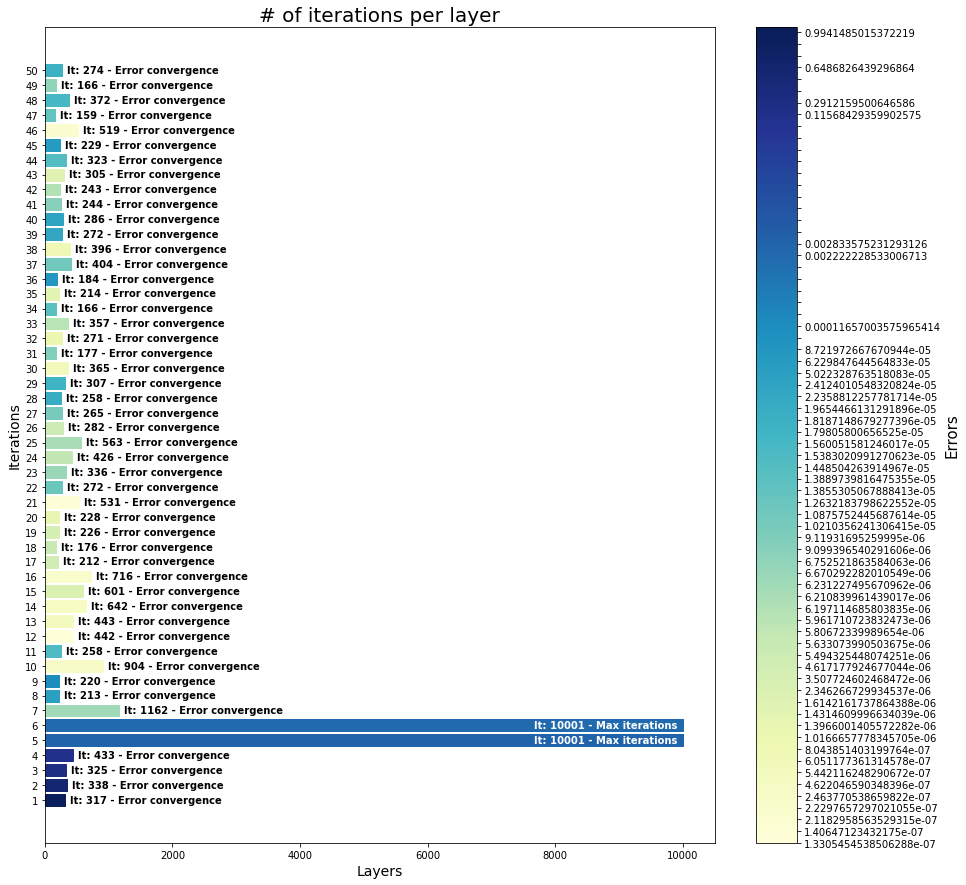

In [5]:
layers, iterations, reasons = result_class.get_n_iterations_with_stop_reason()
prepare_plot_iterations(x=layers, y=iterations, reasons=reasons, errors=errors, 
                        title="# of iterations per layer", xlabel="Layers", ylabel="Iterations", yticks=layers, size=(15,15));

## Error per each layer
It may be also interesting to see how the error converged per each layer.<br>
Mainly, when switching to log scale, we can see how slow the error decays for 5 and 6, reaching therefore the max iterations before converging. Moreover, still with the log scale, we can identify the steps in which the learning rate was reduce to avoid big oscillations.<br>
Constant learning rates were also tried, but the necessity of a decaying one was given by the very slow convergence and start of oscillations for very small values (mostly because of the very low precision parameters).<br>
An interesting follow up would be to see how the error curves change with different decaying learning rate.

In [6]:
def update(n_layer = 1, log_scale = False):
    l_errors = result_class.get_errors_per_layer(str(n_layer))
    prepare_plot(x=range(len(l_errors)), y=l_errors, 
                 title=f"Error for {n_layer} layer(s)", xlabel="Iterations", ylabel="Error", 
                 lineformat="b-", log_scale=log_scale, size=(15, 5))
interact(update, n_layer = widgets.IntSlider(value=1, min=1, max=len(done_layers), step=1), log_scale = False);

interactive(children=(IntSlider(value=1, description='n_layer', max=50, min=1), Checkbox(value=False, descript…

## Best layers number
As can be seen in the first error plot, the best value was obtained for 12 layers.

Best Layers number -> 12 - Error: 1.3305454538506288e-07


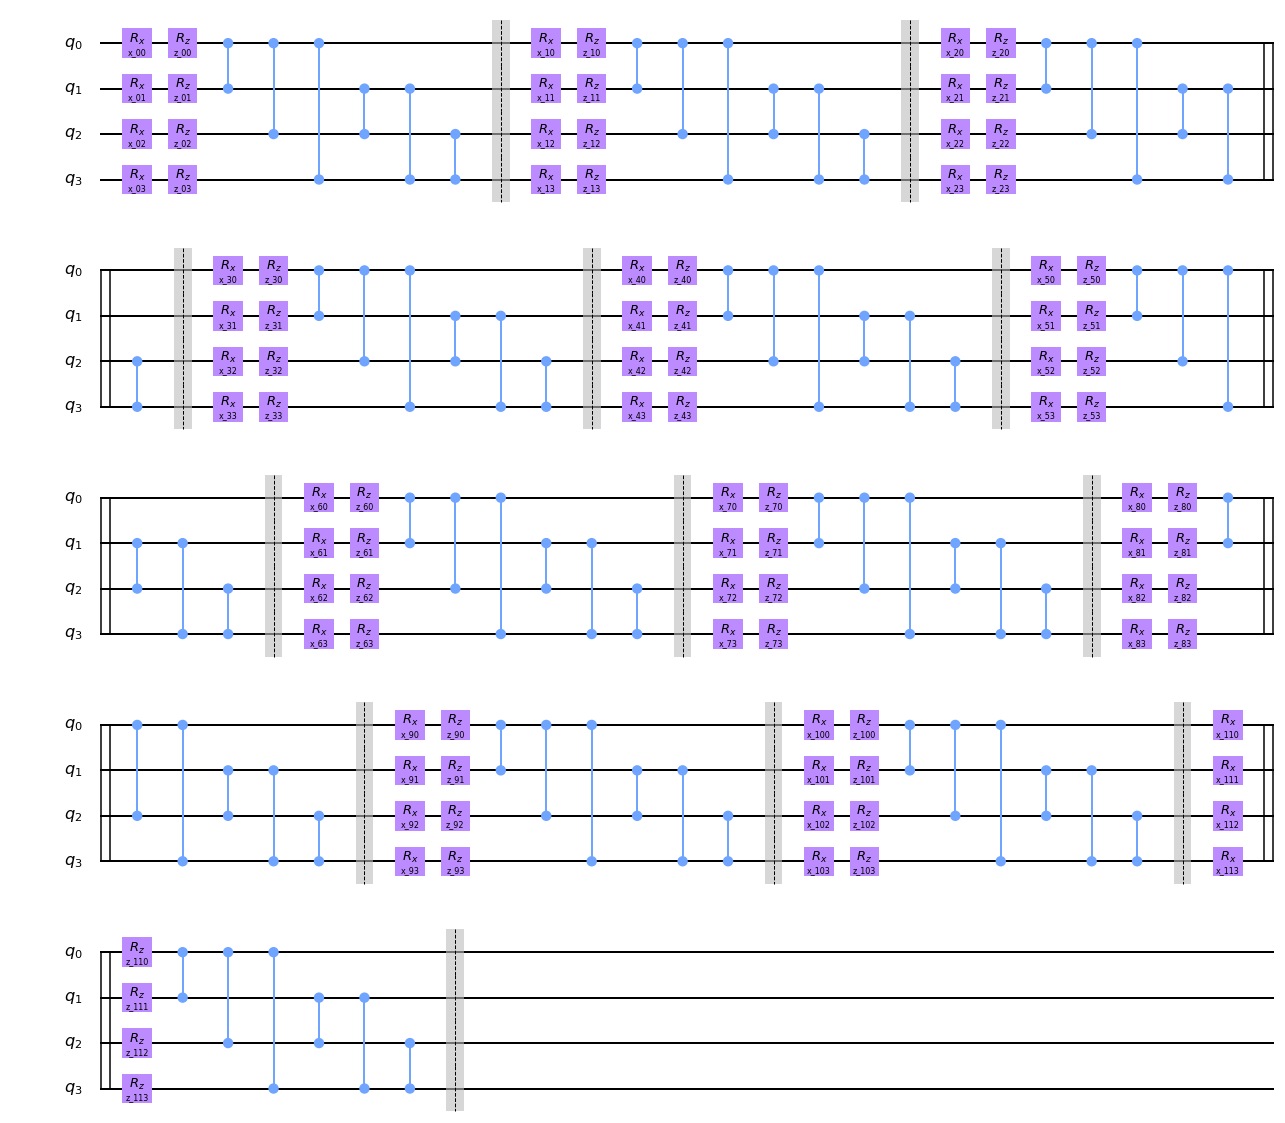

In [7]:
best_layers, best_error, best_params = result_class.get_lowest_set_up()
print(f"Best Layers number -> {best_layers} - Error: {best_error}")
circuit_config = {
    'target_state': Statevector(result_class.result['target_state']),
    'layers': int(best_layers),
    'nqubit': result_class.result['nqubit']
}
circuit_model = CircuitModel(**circuit_config)
circuit_model.circuit.draw(output='mpl')

## State comparison

Even if the lowest error was obtained for 12 layers, for number of layers bigger than 5 the error is so small that the difference can barely be appreciated.<br>
To have a visual proof of this, below are plotted the target state (middle), the best state (right) obtained with 12 layers and an interactive state where layer can be set with the slider (left).

In [8]:
target_state = Statevector(result_class.result['target_state'])
best_state = Statevector(circuit_model.get_state(best_params))
def update(n_layers = 1):
    circuit_config_temp = {
        'target_state': target_state,
        'layers': n_layers,
        'nqubit': result_class.result['nqubit']
    }
    circuit_model_temp = CircuitModel(**circuit_config_temp)
    params = result_class.get_latest_params(str(n_layers))
    state_l = Statevector(circuit_model_temp.get_state(params))
    prepare_state_vector_plots(state_l, target_state, best_state, n_layers, best_layers, size=(20, 7))
interact(update, n_layers = widgets.IntSlider(value=1, min=1, max=len(done_layers), step=1));

interactive(children=(IntSlider(value=1, description='n_layers', max=50, min=1), Output()), _dom_classes=('wid…

## Bonus
For the bonus part the gates in the layer were modified. Since we know that IBM transpile all the gates into the base [u3, cx], it may be interesting to see what are the result using them. <br>
To this purpose the new layer structure is the following:

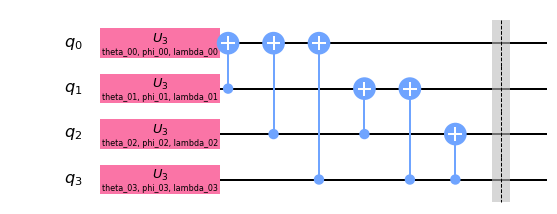

In [9]:
circuit_config = {
    'target_state': None,
    'layers': int(1),
    'nqubit': 4,
    'bonus_question': True
}
circuit_model = CircuitModel(**circuit_config)
circuit_model.circuit.draw(output='mpl')

Changes performed are:
* The two rotation gates (Rz and Rx) are now replaced by a general rotation U3, hence increasing the parameters per layer;
* The Cz are now replaced by Cx gates. The direction is not random, in fact transpiling the circuit of the standard problem, I got the intuition that reversing the direction may help aggregating some rotations and reduce the number of layers needed for a good solution. While it turned out that this didn't improve the results compared to previous circuit, it definitely gave better results with respect the bonus circuit without Cx gates inversion. 

In [10]:
result_class_bonus = Results(result_filename='results_bonus.json')
result_json_bonus = result_class_bonus.result['results_per_n_layers']
errors_bonus = result_class_bonus.get_last_errors()  # List of errors per layer
done_layers_bonus = result_class_bonus.done_layers   # List of layers numbers

As it can be seen in the below plot, the new circuit didn't improve much. While giving slightly better results for some value of layers number, it still seems to converge around $10^{-5}$.<br>
Moreover, having more parameters per layer it needed on average more iterations to converge, see below histogram.

In [11]:
def update(log_scale = False):
    ax = prepare_plot(x=done_layers[:len(done_layers_bonus)], y=errors[:len(done_layers_bonus)], 
                      title="Error per number of layers", xlabel="# Layers", ylabel="Error", 
                      lineformat="y--", pointformat="b.", label="Standard", xticks=done_layers, 
                      log_scale=log_scale, size=(15, 5));
    prepare_plot(x=done_layers_bonus, y=errors_bonus, title="Error per number of layers", 
                 xlabel="# Layers", ylabel="Error", lineformat="c--", pointformat="g.", 
                 label="Bonus", xticks=done_layers, log_scale=log_scale, size=(15, 5), ax=ax);
    ax.legend(fontsize="x-large")
interact(update, log_scale = False);

interactive(children=(Checkbox(value=False, description='log_scale'), Output()), _dom_classes=('widget-interac…

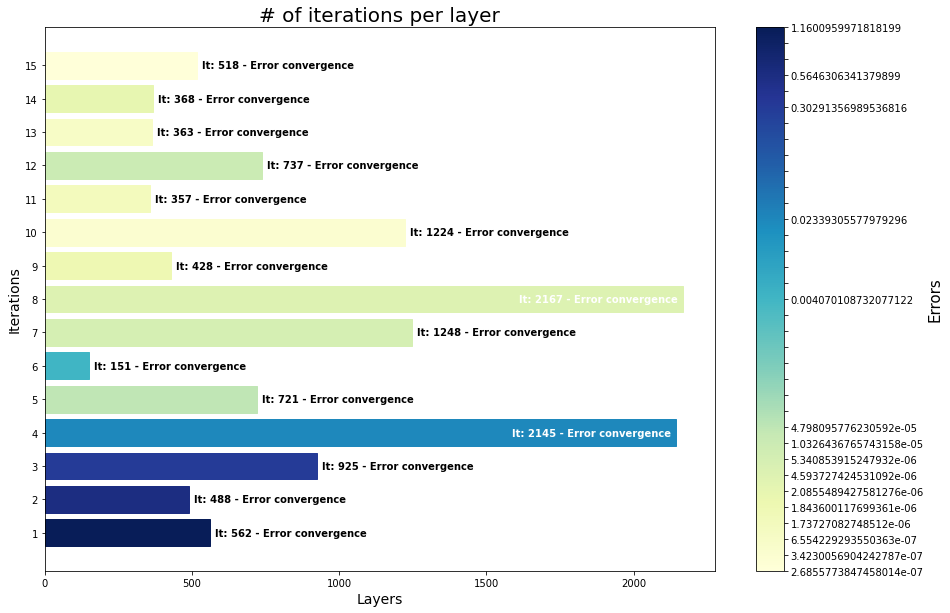

In [12]:
layers, iterations, reasons = result_class_bonus.get_n_iterations_with_stop_reason()
prepare_plot_iterations(x=layers, y=iterations, reasons=reasons, errors=errors_bonus, 
                        title="# of iterations per layer", xlabel="Layers", ylabel="Iterations", yticks=layers, size=(15,10));

## Possible next steps
In addition to the basic improvements to the model, like mentioned before: 
* improving learning rate decay and find better convergence checks; 
* restructure the code in building blocks to build different loss function, i.e. circuits, easily; 

it would be a good option also to continue exploring the bonus circuit. <br>
Meaning that will be interesting to use the Cx gates as discrete parameter to decide if present and in which direction, so that to not have them static in every layer. This will give more freedom and maybe better convergence already for small number of layers.<br>
This set-up could follow the ideas in https://arxiv.org/abs/1803.04114, even though in the paper there is more freedom not having the concept of layers.